# Esempi di regressione logistica nell'analisi del linguaggio

In [3]:
!pip install scikit-learn pandas matplotlib


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

## Sentiment analysis delle brevi recensioni

Proviamo ad usare Python per allenare un modello di regressione logistica per eseguire un task di **sentiment analysis** analologo a quello che abbiamo usato come esmpio a lezione.

## I dati

Prendiamo una piccola sezione del dataset contenuto nel corpus [Multiemo](https://clarin-pl.eu/dspace/handle/11321/798), un corpus multilingue contenente recensioni in 11 lingue in vari domini. Scegliamo i dati relativi al dominio *medico* in lingua italiana.

Questo è un esempio del tipo di testi conenuti:


>Super dottore e uomo da grande C . Grande esperienza e diagnosi accurate . Grande pazienza per gli anziani . Mi prendo cura della mia vecchia mamma da anni, e dico che siamo molto fortunati ad avere un medico del genere. Non so davvero cosa avremmo fatto se non fosse stato per il medico. Grazie a questo, mia madre è viva. Ogni visita ad uno specialista viene consultata con lui e penso che sia meglio di chiunque altro. Abbiamo una fiducia quasi illimitata in lui. Puoi fare molto di buono per il tuo medico ancora da scrivere. Purtroppo ha molti pazienti, è sovraccarico di lavoro (per questo temo anche per la sua salute) e l'accesso a lui è difficile ma sempre possibile. `__label__meta_plus_m`


La classificazione è a 5 categorie: positivi, negativi, neutri, ambigui. Scartiamo tutti i testi classificati come ambigui e neutri

## Preprocessing

La prima cosa che dobbiamo fare è trasformare i nostri testi in un vettore di *features* il cui impatto vogliamo misurare.

Prendiamo spunto dalla discussione in [Jurafsky e Martin](https://web.stanford.edu/~jurafsky/slp3/) e usiamo queste 6 variabili:

- nr. di parole positive
- nr. di parole negative
- contiene 'polarity shifters' (e.g. no, non, nessuno)? 1 se il testo ne contiene almeno una, altrimenti 0
- conto di pronomi di 1a o 2a persona
- punto esclamativo? 1 se il testo contiene il punto esclamativo; 0 in caso contrario
- log del numero totale di parole

Per effettuare la classificazione in parole positive e negative (e anche per ottenere la lista dei *polarity shifters*) ho utilizzato un [lessico di polarità dell'italiano](https://dspace-clarin-it.ilc.cnr.it/repository/xmlui/handle/20.500.11752/ILC-73) sviluppato dall'ILC-CNR.

Questo è il codice che ho utilizzato per trasformare ogni testo in un vettore di feature:

```python
def process_text(txt):
    doc = nlp(txt)
    positive_words = 0
    negative_words = 0
    hasShifters = 0
    pronouns = 0
    hasExclamations = 0
    log_nr = math.log(len(doc))

    for tok in doc:
        pol = polarity_entries.get(tok.lemma_, 'null')
        if pol == 'positive':
            positive_words += 1
        elif pol == 'negative':
            negative_words += 1
        
        if tok.lemma_ in polarity_shifters:
            hasShifters = 1

        if tok.lemma_ in ['io', 'tu', 'noi', 'voi']:
            pronouns += 1
        
        if tok.lower_ == '!':
            hasExclamations = 1
    return positive_words, negative_words, hasShifters, pronouns, hasExclamations, log_nr
```

Possiamo caricare il dataset (il testo delle recensioni non è riprodotto per comodità)

In [5]:
df = pd.read_csv('../data/recensioni_feats.tsv', sep='\t', index_col=0)
df.head()

,PosWords,NegWords,hasShift,NrPron,hasExcl,logNr,Label
LineNr.,,,,,,,
1,13,2,1,0,0,4.905275,1
2,8,2,1,0,0,4.941642,0
3,10,5,0,0,0,4.779123,1
4,13,3,1,0,0,4.553877,1
5,12,4,1,0,1,5.497168,1


quante recensioni pos/neg ci sono?

In [6]:
df.Label.value_counts()

0    957
1    764
Name: Label, dtype: int64

### Alleniamo il modello

Usiamo la libreria `sckitlearn` per creare ed allenare il modello. La funzione per addestrare il modello richiede due argomenti obbligatori:
- una matrice che contiene la serie di features; immaginatela come una tabella con tante righe quante sono le nostre osservazioni e tante colonne quante sono le features
- un vettore con le classificazioni corrette

Cominciamo a creare l'input

In [7]:
X = df[['PosWords', 'NegWords', 'hasShift', 'NrPron', 'hasExcl', 'logNr']].to_numpy()
y = df.Label.to_numpy()

Ora creiamo il modello. "Creare" in questo caso non vuol dire *allenare* sui dati. Per ora, vuol solamente dire impostare il funzionamento generale del modello, settando alcuni parametri iniziali. La classe di modelli `LogisticRegression` di `sklearn` ha molti parametri iniziali che possono essere regolarati, come si può vedere dalla sua documentazione:

In [8]:
help(LogisticRegression)

Help on class LogisticRegression in module sklearn.linear_model._logistic:

class LogisticRegression(sklearn.linear_model._base.LinearClassifierMixin, sklearn.linear_model._base.SparseCoefMixin, sklearn.base.BaseEstimator)
 |  LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
 |  
 |  Logistic Regression (aka logit, MaxEnt) classifier.
 |  
 |  In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
 |  scheme if the 'multi_class' option is set to 'ovr', and uses the
 |  cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
 |  (Currently the 'multinomial' option is supported only by the 'lbfgs',
 |  'sag', 'saga' and 'newton-cg' solvers.)
 |  
 |  This class implements regularized logistic regression using the
 |  'liblinear' library, 'newton-cg', 's

Noi lavoriamo con i valori di default.

In [9]:
model = LogisticRegression(solver='liblinear', random_state=0)

Ora possiamo addestrare ("fare il fit") dei dati!

In [10]:
model.fit(X, y)

LogisticRegression(random_state=0, solver='liblinear')

Ecco fatto! Possiamo vedere quali sono i pesi e quale è l'intercetto calcolato dal modello?

In [11]:
model.intercept_

array([3.51674717])

In [12]:
model.coef_

array([[ 0.08800761, -0.16689316, -1.32284647, -0.03628668,  0.31080057,
        -0.60220009]])

Possiamo vedere le probabilità predette sui dati di training:

In [13]:
model.predict_proba(X)[:10]

array([[0.48743856, 0.51256144],
       [0.60149119, 0.39850881],
       [0.33528692, 0.66471308],
       [0.47627408, 0.52372592],
       [0.60280713, 0.39719287],
       [0.51425592, 0.48574408],
       [0.6244055 , 0.3755945 ],
       [0.32758341, 0.67241659],
       [0.75234066, 0.24765934],
       [0.84127996, 0.15872004]])

In [14]:
model.predict(X)[:10]

array([1, 0, 1, 1, 0, 0, 0, 1, 0, 0])

### Valutazione

#### Riusiamo I dati di training

Facile, no? Adesso, però, è necessario **valutare** il nostro modello, ovvero sapere quale capacità predittiva abbia il nostro modello! Come facciamo?

Una risposta semplice semplice è quella di testare il nostro modello sugli stessi dati su cui si è addestrato

In [15]:
model.score(X, y)

0.6717024985473562

Uuuh... il nostro modello ha classificato correttamente solo il 67% dei testi di training... numeri non esattamente entusiasmanti!

Questo numero, peraltro non ci dice molto. Dove sbaglia il nostro classificatore? Quanti `positivi` classificati come `negativi` e viceversa abbiamo?

Per avere questo dato possiamo usare una cosiddetta `matrice di confusione` (confusion matrix), ovvero una tabella di errori di predizioni che ci restituisca il numero di:
- 0 classificati correttamente (veri negativi)
- 0 classificati erroneamente (falsi negativi)
- 1 classificati correttamente (veri positivi)
- 1 classificati erroneamente (falsi positivi)

In [16]:
confusion_matrix(y, model.predict(X))

array([[788, 169],
       [396, 368]])

In [17]:
from matplotlib import pyplot as plt

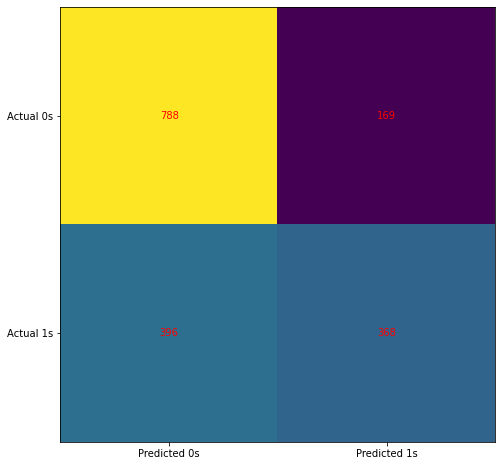

In [18]:
cm = confusion_matrix(y, model.predict(X))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()


In [19]:
print(classification_report(y, model.predict(X)))

              precision    recall  f1-score   support

           0       0.67      0.82      0.74       957
           1       0.69      0.48      0.57       764

    accuracy                           0.67      1721
   macro avg       0.68      0.65      0.65      1721
weighted avg       0.67      0.67      0.66      1721



#### Usare un test set

Il corpus Multiemo, però, suddivide i dati in 3 parti: train, dev, test. La cosa più corretta da fare è usare i dati di test per valutare le performance del nostro modello. I dati sono già stati organizzati in features e label. Carichiamoli e vediamo!

In [45]:
df_test = pd.read_csv('../data/recensioni_feats_TEST.tsv', sep='\t', index_col=0)
df_test.head()

,PosWords,NegWords,hasShift,NrPron,hasExcl,logNr,Label
LineNr.,,,,,,,
1,5,4,1,0,0,4.532599,0
2,8,3,1,0,0,4.859812,0
3,35,14,1,0,0,5.814131,0
4,1,0,0,0,0,3.951244,1
5,16,7,1,0,0,5.099866,1


In [46]:
X_test = df_test[['PosWords', 'NegWords', 'hasShift', 'NrPron', 'hasExcl', 'logNr']].to_numpy()
y_test = df_test.Label.to_numpy()

In [47]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       133
           1       0.42      0.98      0.58        97

    accuracy                           0.41       230
   macro avg       0.21      0.49      0.29       230
weighted avg       0.18      0.41      0.25       230



Vediamo ancora la matrice di confusione

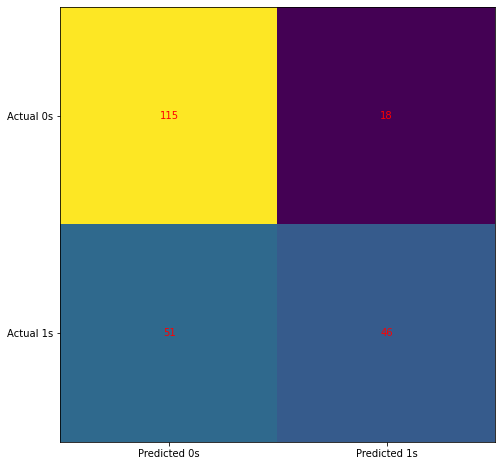

In [23]:
cm = confusion_matrix(y_test, model.predict(X_test))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()


Cosa succederebbe se predicessimo sempre la classe più frequente (ovvero: positivo, 0)? Azzeccheremmo comunque un buon numero di previsioni. Otterremmo, cioè, una accuratezza del 58%. È questo il numero che ci dà una stima più realistica del miglioramento approtato dal nostro modello.

In [24]:
print(classification_report(y_test,  [0] * len(y_test) ))

              precision    recall  f1-score   support

           0       0.58      1.00      0.73       133
           1       0.00      0.00      0.00        97

    accuracy                           0.58       230
   macro avg       0.29      0.50      0.37       230
weighted avg       0.33      0.58      0.42       230



/opt/homebrew/Caskroom/miniforge/base/envs/data/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/data/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/data/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Qui possiamo chiedere al modello di visualizzare le probabilità delle prime 10 osservazioni del test. Per ogni riga, il primo numero è la probabilità della classe 0, il secondo quella della classe 1.

Ricordatevi che abbiamo posto la soglia a 0.5: la classe che supera la soglia è quella assegnata dal nostro classificatore. Ad es., nel primo caso 0 ha una probabilità uguale a 0.68; per il nostro classificatore il primo testo sarà positivo!

In [25]:
model.predict_proba(X_test)[:10]

array([[0.68204065, 0.31795935],
       [0.62931923, 0.37068077],
       [0.63728677, 0.36271323],
       [0.22700238, 0.77299762],
       [0.65415864, 0.34584136],
       [0.63292361, 0.36707639],
       [0.48275403, 0.51724597],
       [0.51694238, 0.48305762],
       [0.49653384, 0.50346616],
       [0.72552642, 0.27447358]])

Qui possiamo chiedere di darci in output le label che corrispondono alla probabilità:

In [26]:
model.predict(X_test)[:10]

array([0, 0, 0, 1, 0, 0, 1, 0, 1, 0])

O addirittura possiamo stampare `positivo` e `negativo` come etichetta corrispondente a 0 e 1

In [27]:
for res in model.predict(X_test)[:10]:
    if res == 0:
        print("positivo")
    else:
        print("negativo")

positivo
positivo
positivo
negativo
positivo
positivo
negativo
positivo
negativo
positivo


Che cos'è il **bias** $b$ che osserviamo nella proprietà del modello `model.intercept_` e che compare nella formula:

$z = \vec{w} \cdot \vec{x} + b$

Ricordiamo che $b$, in questa formula, equivale a:

In [28]:
model.intercept_

array([3.51674717])

Se avessimo un testo $x$ rappresentato da un vettore contenente solo una sequenza di 0 (ovvero: se tutte le feature del nostro testo fossero uguali a 0) otterremmo queste probabilità

In [29]:
model.predict_proba([[0] * 6])

array([[0.02883946, 0.97116054]])

Ricordate che le probabilità (meglio, la probabilità $p$ della classe 1, dato che la probabilità della classe 0 è semplicemente 1-p) sono calcolate applicando la funzione logistica a $z$.

Dunque, che risultato otterremo se applicassimo una funzione ci permette di passare dalla probabilità della classe 1 quando tutte le features sono 0 al nostro coefficiente $z$?

La funzione che ci permette di passare dalle probabilità ai log-odds ($z$) è la cosidetta funzione *logit*:

$z = \log \left(\frac{p}{1-p}\right)$

Questo è il codice python che serve a calcolarla:

In [30]:
import math

def logit(x):
    # le prima 2 righe di codice sono un buon modo per assicurarci che il valore passato 
    # sia una probabilità valida (tra 0 e 1)
    if x <= 0 or x >= 1:
        raise ValueError("Probability must be between 0 and 1, exclusive.")
    
    return math.log(x / (1 - x))

Proviamola con la probabilità della classe 1 quando tutti i valori delle feature sono 0 (ovvero $p=0.97116054$)

In [31]:
logit(0.97116054)

3.5167472010845353

Il nostro bias è:

In [32]:
model.intercept_

array([3.51674717])

Il bias non è nient'altro che il valore di $z$ quando il prodotto tra le feature ($\vec{x}$) e i pesi ($\vec{w}$) risulta 0

*CVD*!

Un aspetto utile della regressione logistica è che possiamo usare i pesi ($\vec{w}$) per farci un'idea delle variabili che influiscono di più sulla classificazione: l'idea (molto grossolana) è che più alto è il peso, più alta sarà l'influenza della feature in questione.

Possiamo (informalmente) utilizzare [queste formule](https://sefiks.com/2021/01/06/feature-importance-in-logistic-regression/) per avere un'idea dell'importanza relativa delle diverse features all'interno dell'equazione del modello. Ma una lettura attenta di un buon manuale di statistica per linguisti, come quello di [Gries](https://www.degruyter.com/document/doi/10.1515/9783110718256/html) citato più sotto. è fondamentale per chi volesse utilizzare i modelli lineari più seriamente per lo studio linguistico!

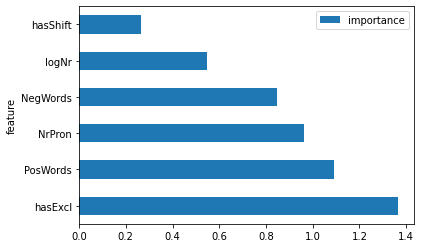

In [33]:
feature_importance = pd.DataFrame(['PosWords', 'NegWords', 'hasShift', 'NrPron', 'hasExcl', 'logNr'], columns = ["feature"])
feature_importance["importance"] = pow(math.e, model.coef_[0])
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
ax = feature_importance.plot.barh(x='feature', y='importance')
plt.show()

## Studio Linguistico

Il libro *Statistics for Linguistics with R: A Practical Introduction* ([vedi qui](https://www.degruyter.com/document/doi/10.1515/9783110718256/html)) di S. Gries contiene una dettagliata e splendida spiegazione dell'uso della regressione logistica (insieme ad altri modelli) per lo studio linguistico.

Tra i vari dataset di esempio, ce n'è uno molto interessante (usato da Gries per illustrare la regressione logistica in contesto di studio quantitativo) relativo al posizionamento delle subordinate temporali e causali rispetto alla principale in un corpus misto inglese e tedesco. È riprodotto qui (dalla seconda ed. che io possiedo) nel file `data/clauseorder.csv`. 

Carichiamolo e diamogli un'occhiata

In [34]:
df = pd.read_csv('../data/clauseorders.csv', sep='\t')
df.head()

,CASE,ORDER,SUBORDTYPE,LEN_MC,LEN_SC,LENGTH_DIFF,CONJ,MORETHAN2CL
0,4777,sc-mc,temp,4,10,-6,als/when,no
1,1698,mc-sc,temp,7,6,1,als/when,no
2,953,sc-mc,temp,12,7,5,als/when,yes
3,1681,mc-sc,temp,6,15,-9,als/when,no
4,4055,sc-mc,temp,9,5,4,als/when,yes


Quello che noi vogliamo predire è l'ordine delle proposizioni, che qui è registrato nella colonna `ORDER`:

In [35]:
df.ORDER.value_counts()

mc-sc    275
sc-mc    128
Name: ORDER, dtype: int64

In [36]:
feats = ['SUBORDTYPE', 'LEN_MC', 'LEN_SC', 'LENGTH_DIFF',
       'CONJ', 'MORETHAN2CL']
to_factorize = ['SUBORDTYPE', 'CONJ', 'MORETHAN2CL']

In [37]:
for col in to_factorize:
    df[col] = df[col].factorize()[0]

df.head()

,CASE,ORDER,SUBORDTYPE,LEN_MC,LEN_SC,LENGTH_DIFF,CONJ,MORETHAN2CL
0,4777,sc-mc,0,4,10,-6,0,0
1,1698,mc-sc,0,7,6,1,0,0
2,953,sc-mc,0,12,7,5,0,1
3,1681,mc-sc,0,6,15,-9,0,0
4,4055,sc-mc,0,9,5,4,0,1


Qui *non* ripeteremo le analisi molto sofisticate che Gries discute nel suo libro. Ci limitiamo a giocare un po' con un modello creato con `sklearn`

In [38]:
# trasformiamo le due categorie in 0 e 1: sc-mc diventa 0
y = df.ORDER.factorize()[0]

In [39]:
model = LogisticRegression(solver='lbfgs', penalty='none', random_state=0)

In [40]:
X = df[feats].values
model.fit(X, y)

LogisticRegression(penalty='none', random_state=0)

In [41]:
model.score(X, y)

0.7667493796526055

In [42]:
model.coef_

array([[ 2.62135434, -0.01808965,  0.00706139, -0.02515104,  0.06792462,
        -0.76710495]])

Possiamo (informalmente) utilizzare [queste formule](https://sefiks.com/2021/01/06/feature-importance-in-logistic-regression/) per avere un'idea dell'importanza relativa delle diverse features all'interno dell'equazione del modello. Ma una lettura attenta di Gries è fondamentale per chi volesse utilizzare i modelli lineari più seriamente per lo studio linguistico!

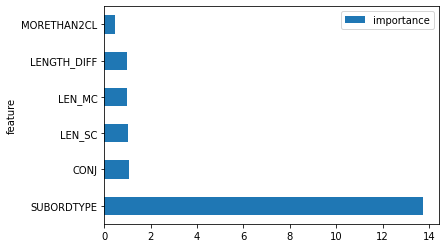

In [43]:
feature_importance = pd.DataFrame(feats, columns = ["feature"])
feature_importance["importance"] = pow(math.e, model.coef_[0])
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
ax = feature_importance.plot.barh(x='feature', y='importance')
plt.show()

In [44]:
feature_importance

,feature,importance
0,SUBORDTYPE,13.754339
4,CONJ,1.070285
2,LEN_SC,1.007086
1,LEN_MC,0.982073
3,LENGTH_DIFF,0.975163
5,MORETHAN2CL,0.464355
